In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import re
import statsmodels.formula.api as smf


/usr/local/lib/python2.7/dist-packages/scipy/__init__.py:111: UserWarning: Numpy 1.6.2 or above is recommended for this version of scipy (detected version 1.6.1)
  UserWarning)


# Load the data 

In [3]:
list_df = []
for counter in range(1,13):
    filename = '../data/{}-data.csv'.format(counter)
    list_df.append(pd.read_csv(filename))
data = pd.concat(list_df)
data = data.sort(['YEAR','MONTH','DAY_OF_MONTH','DEP_TIME'])
print 'Total number of reords:', len(data)

Total number of reords: 6096762


# Compile airport coordinate data 

In [4]:
data_airports = pd.read_csv('../airports.csv', sep='|')

# Dictionary mapping each (city, state) tuple in airports file to
# its coordinates
dict_airports = {}


print data_airports.columns
for i,row in data_airports.iterrows():
    try:
        city = row['city'].strip()
    except:
        continue
    state = row['state']
    dict_airports[(city, state)] = (row['lat'], row['long'])



Index([u'iata', u'airport', u'city', u'state', u'country', u'lat', u'long'], dtype='object')


In [5]:
def find_match(target_city, target_state):
    '''
    Attempt to find a match for the city given by target_city,
    target_state in dict_airports.
    @return (name, state) for the found match.
    '''
    target_city_split1 = target_city.split('/')
    target_city_split2 = target_city.split('-')
    
    for city in target_city_split1:
        if (city, target_state) in dict_airports:
            return (city, target_state)
    
    for city in target_city_split2:
        if (city, target_state) in dict_airports:
            return (city, target_state)
    
    city = re.sub('Fort', 'Ft\.', city)
    city = re.sub('St. ', 'St ',  city)

    if (city, target_state) in dict_airports:
            return (city, target_state)
    return None
        

## Generate normalized city, lat, long dataframe 

In [6]:
# List of cities appearing in the data
list_cities = list(data['ORIGIN_CITY_NAME'].unique())
print "Number of unique city names in database: ", len(list_cities)

# Maps each actual airport string (in list_cities) to a
# coordinate pair
dict_coordinates = {}

counter_error = 0
counter_matched = 0
for city in list_cities:
    name, state = city.split(',')
    state = state.strip()
    name = name.strip()
    try:
        dict_coordinates[city] = dict_airports[(name, state)]
    except:
        counter_error += 1
        match = find_match(name, state)
        if match:
            counter_matched += 1
            dict_coordinates[city] = dict_airports[match]

print len(list_cities), counter_error, counter_matched

data_coordinates = [(key, value[0], value[1]) for key, value in dict_coordinates.iteritems()]
data_coordinates = pd.DataFrame(data_coordinates, columns = ['city', 'lat', 'long'])

Number of unique city names in database:  307
307 45 33


## Merge full data with coordinates table

In [7]:
data_merged = pd.merge(data, data_coordinates, how='inner', left_on='ORIGIN_CITY_NAME', right_on='city' )
data_merged.rename(columns={'lat':'ORIGIN_LAT', 'long': 'ORIGIN_LONG'}, inplace=True)

In [8]:
data_merged = pd.merge(data_merged, data_coordinates, how='inner', left_on='DEST_CITY_NAME', right_on='city' )
data_merged.rename(columns = {'lat':'DEST_LAT', 'long': 'DEST_LONG'}, inplace=True)

In [9]:
n1,n2 = len(data_merged), len(data)
print n1,n2
print "%0.2f percent of the records have matching coordinates \
for both origin and destination airports" % (100 * 1-(n2-n1)/float(n2))

5866972 6096762
99.96 percent of the records have matching coordinates for both origin and destination airports


## Add columns for LAT and LONG displacements 

In [10]:
data_merged['D_LAT'] = data_merged['DEST_LAT'] - data_merged['ORIGIN_LAT']
data_merged['D_LONG'] = data_merged['DEST_LONG'] - data_merged['ORIGIN_LONG']

# Smaple the data 

In [11]:
data_sample = data_merged.iloc[::60]
print 'Size of the working subsample: ',len(data_sample)

Size of the working subsample:  97783


# Exploration 

## Clean up the data, remove NA

In [28]:
df = data_sample[['ARR_DELAY', 'DEP_DELAY', 'D_LAT', 'D_LONG', 'DISTANCE', 'AIR_TIME']].dropna()

## Standardize D_LAT and D_LONG, DISTANCE 

In [29]:
# Center and normalize coordinate displacements
for column in ['D_LAT', 'D_LONG']:
    df[column] -= df[column].mean(); df[column] /= df[column].std()

# Normalize DISTANCE
df['DISTANCE'] /= df['DISTANCE'].std()


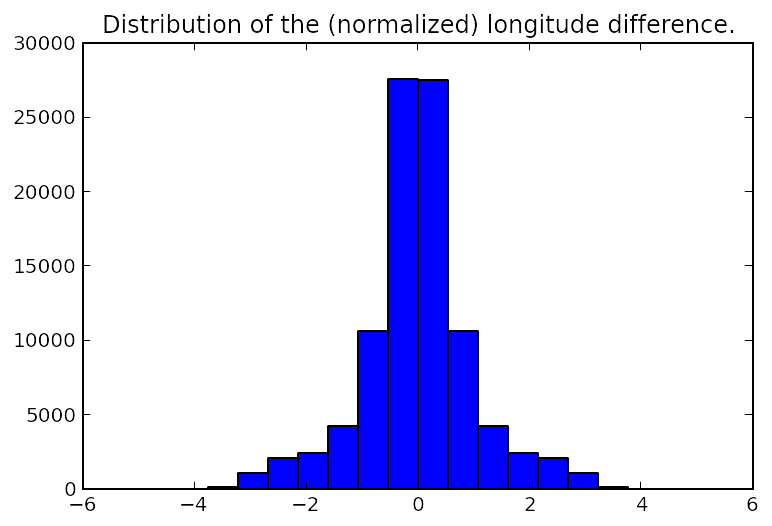

In [14]:
tmp = plt.hist(df['D_LONG'],20)
plt.title('Distribution of the (normalized) longitude difference.')

In [62]:

model = 'DEP_DELAY ~ ORIGIN_LAT + ORIGIN_LONG'
model = 'DEP_DELAY ~ ORIGIN_LAT + ORIGIN_LONG + ORIGIN_LAT:ORIGIN_LONG'
model = 'DEP_DELAY ~ ORIGIN_LAT:ORIGIN_LONG'
model = 'DEP_DELAY ~ MONTH + ORIGIN_LAT:ORIGIN_LONG'
model = 'DEP_DELAY ~ MONTH'
model = 'DEP_DELAY ~ MONTH + ORIGIN_LAT + ORIGIN_LONG + ORIGIN_LAT:ORIGIN_LONG'
model = 'ARR_DELAY ~ DISTANCE + D_LAT + D_LONG' # interesting
model = 'AIR_TIME ~ DISTANCE + D_LAT + D_LONG' #interesting


model1 = 'AIR_TIME ~ D_LAT + D_LONG'
# model = 'AIR_TIME ~ D_LAT + D_LONG + D_LONG:D_LAT'
model2 = 'AIR_TIME ~ DISTANCE + D_LAT + D_LONG + D_LONG:D_LAT'
model3 = 'AIR_TIME ~ DISTANCE + np.square(DISTANCE) + D_LAT + D_LONG + D_LONG:D_LAT'
# model = 'AIR_TIME ~  D_LONG:D_LAT'

res1 = smf.ols(model1, data = df).fit()
res2 = smf.ols(model2, data = df).fit()
res3 = smf.ols(model3, data = df).fit()

summary1 = res1.summary()
summary2 = res2.summary()
summary3 = res3.summary()
# print summary1
# print summary2


In [63]:
with open('summary1.tex', 'w') as f:
    f.write(summary1.as_latex())
with open('summary2.tex', 'w') as f:
    f.write(summary2.as_latex())
with open('summary3.tex', 'w') as f:
    f.write(summary3.as_latex())

## Distribution of trajectory angles 

3.10554488642


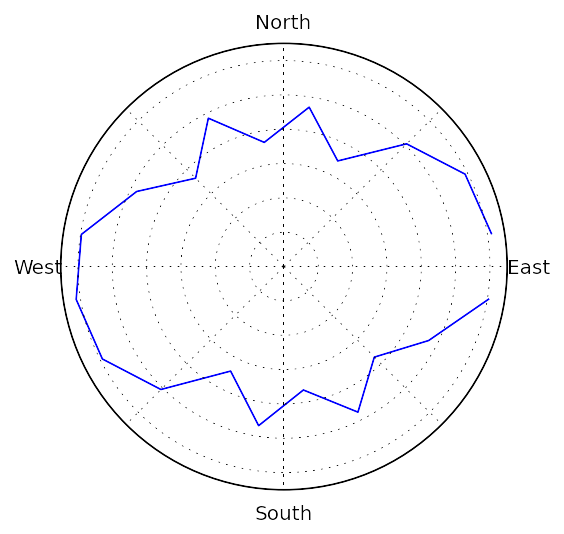

In [65]:
angles = np.arctan(df['D_LONG'] / df['D_LAT']) 
angles += -(np.sign(df['D_LONG']) - 1)/2. * np.pi
angles += 2 * np.pi * -(np.sign(angles) - 1) / 2.
# angles *= 180/np.pi
angles_mean = np.mean(angles)
ns,bins, batches = plt.hist(angles,20, alpha = 0.5)
ax = plt.subplot(111, projection='polar')
ax.plot((bins[1:] + bins[:-1])/2,ns)
# ax.plot([angles_mean]*2, [0,8000],'r-', lw=2)
ax.set_yticklabels([])
ax.set_xticklabels(['East','','North','','West','','South',''])
# plt.xlim([0,360])
print angles_mean
plt.savefig('isotropy.pdf')

## Residuals 

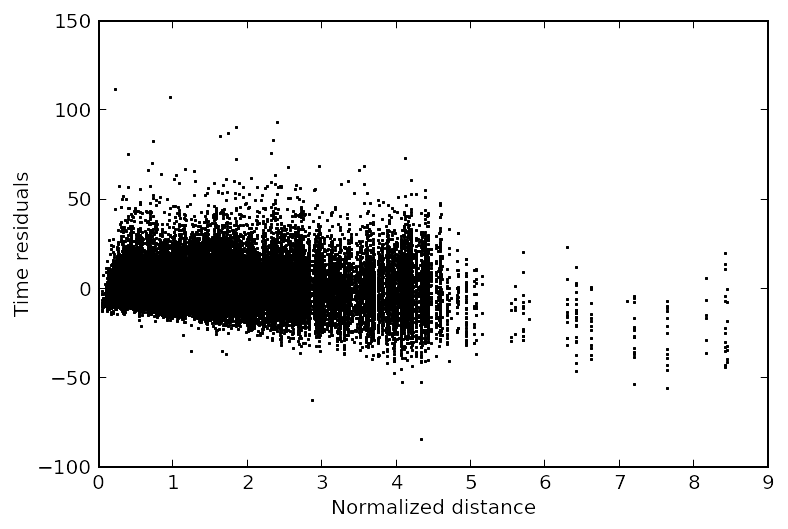

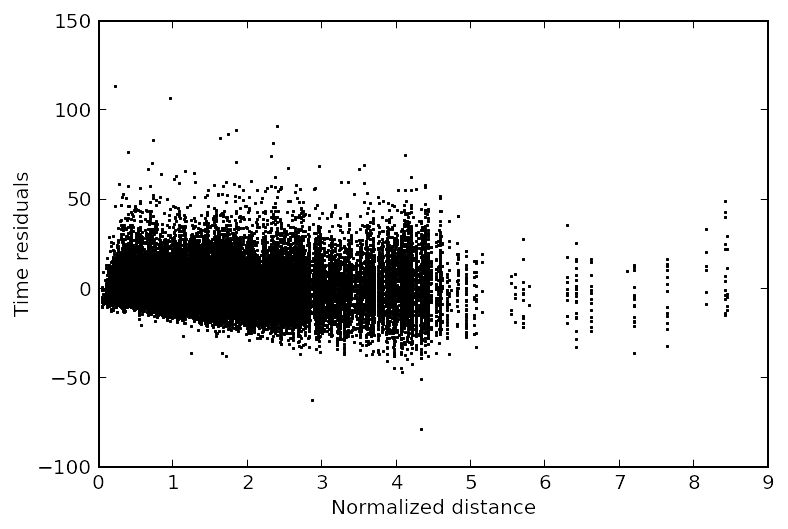

In [69]:

residuals1 = res1.resid
residuals2 = res2.resid
residuals3 = res3.resid


plt.plot(df['DISTANCE'], residuals2, '.k', alpha = 1, markersize = 2)
plt.xlabel('Normalized distance')
plt.ylabel('Time residuals')
plt.savefig('residuals1.png', dpi=150)
plt.figure()
plt.plot(df['DISTANCE'], residuals3, '.k', alpha = 1, markersize = 2)
plt.xlabel('Normalized distance')
plt.ylabel('Time residuals')
plt.savefig('residuals2.png', dpi=150)

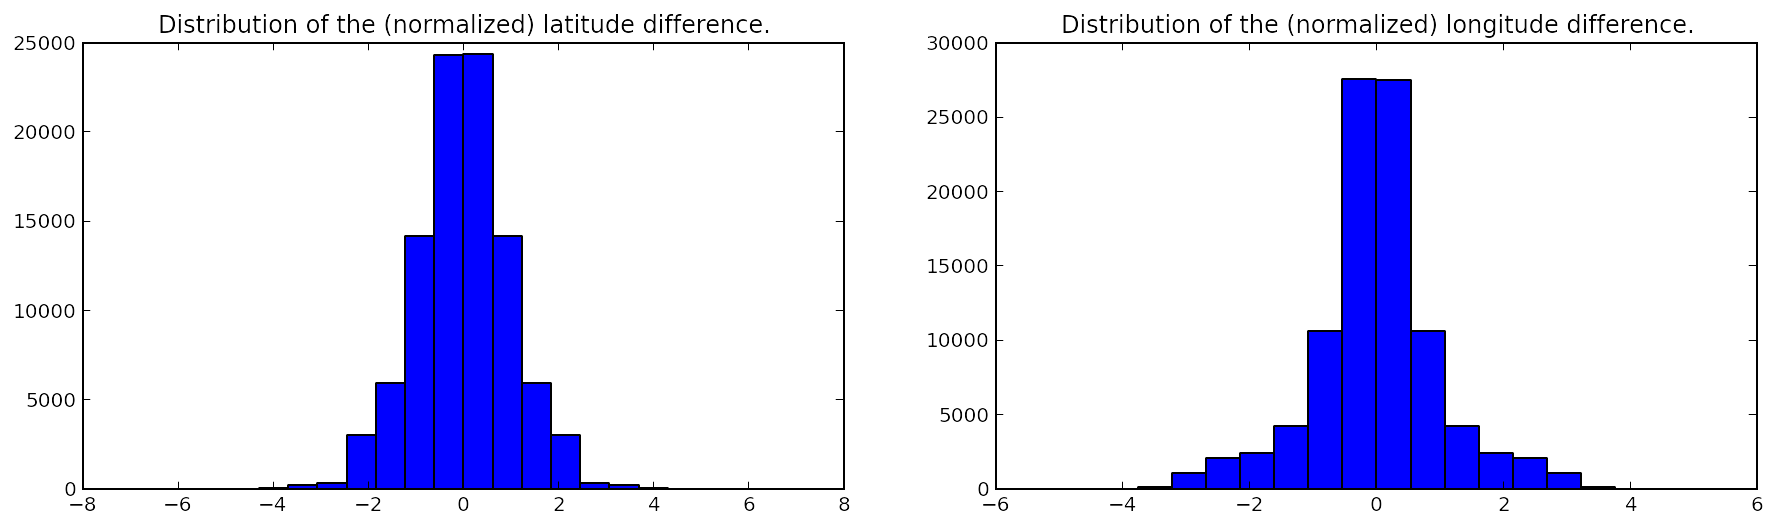

In [19]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
tmp = plt.hist(df['D_LAT'], 20)
plt.title('Distribution of the (normalized) latitude difference.')
plt.subplot(1,2,2)
tmp = plt.hist(df['D_LONG'], 20)
plt.title('Distribution of the (normalized) longitude difference.')

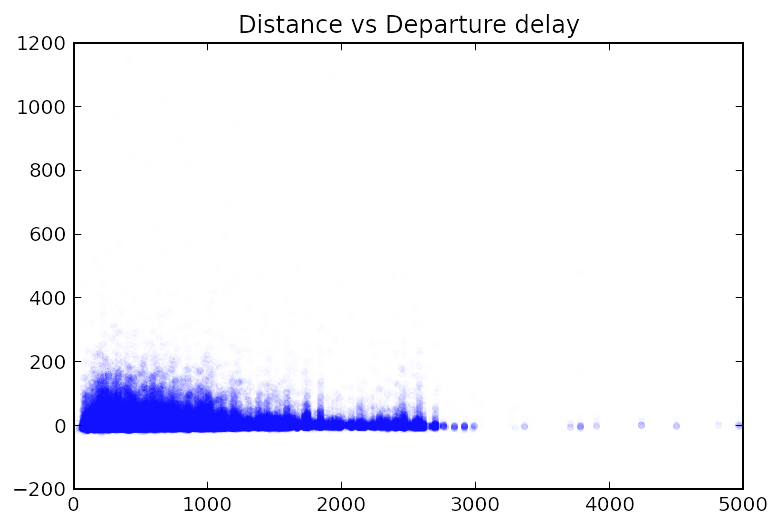

In [20]:
tmp = plt.plot(data_sample['DISTANCE'], data_sample['DEP_DELAY'],'.', alpha = 0.05)
tmp = plt.title('Distance vs Departure delay')

## Arrival vs Departure delay 

                            OLS Regression Results                            
Dep. Variable:              ARR_DELAY   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                 7.154e+05
Date:                Wed, 09 Mar 2016   Prob (F-statistic):               0.00
Time:                        13:17:49   Log-Likelihood:            -3.7560e+05
No. Observations:               96298   AIC:                         7.512e+05
Df Residuals:                   96296   BIC:                         7.512e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -4.6611      0.040   -117.760      0.0

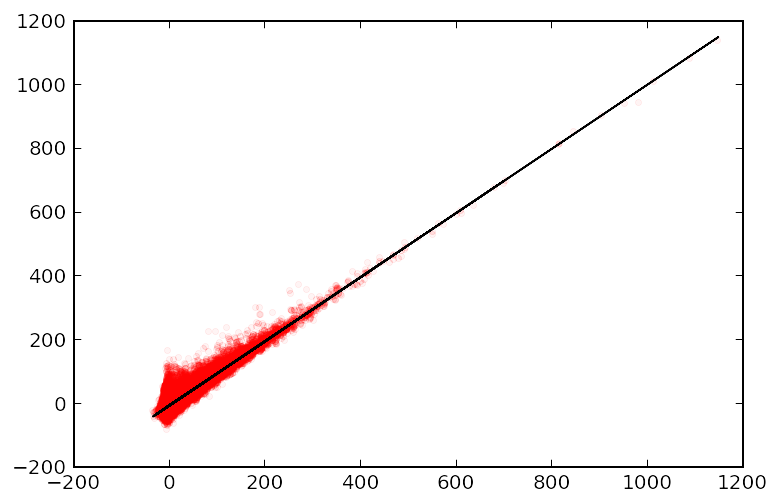

In [21]:
df1 = data_sample[['DEP_DELAY', 'ARR_DELAY']].dropna()
res = smf.ols('ARR_DELAY ~  DEP_DELAY ', data = df1).fit()
print res.summary()
plt.plot(df1['DEP_DELAY'], df1['ARR_DELAY'], '.r', alpha = 0.2 )
plt.plot(df1['DEP_DELAY'], res.fittedvalues,'-k', alpha = 1)
# plt.plot(data_sample['DEP_DELAY'], data_sample['DEP_DELAY'],'-k', alpha = 0.5)

[-16.28416159  39.68161856   0.66108665 ...,  -4.22940984  -4.48263671
  -3.22256587]
[ 0.00016624  0.08562846]


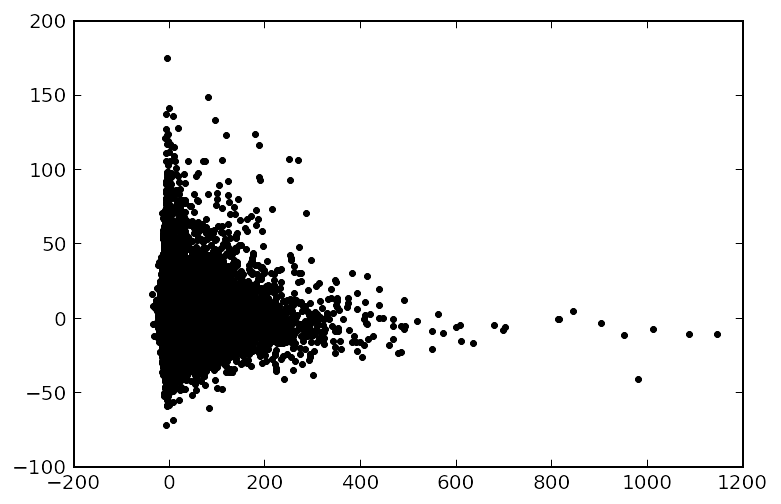

In [22]:
residuals = res.resid.values
print residuals
plt.plot(df['DEP_DELAY'], residuals,'.k')
resid_fit = sm.OLS(residuals[1:], sm.add_constant(residuals[:-1])).fit()
# resid_fit = sm.OLS(residuals[1:], residuals[:-1]).fit()

# print(resid_fit.tvalues[1])
# print(resid_fit.pvalues[1])
# print resid_fit.summary()
print resid_fit.params

## Departure delay vs Departure time 

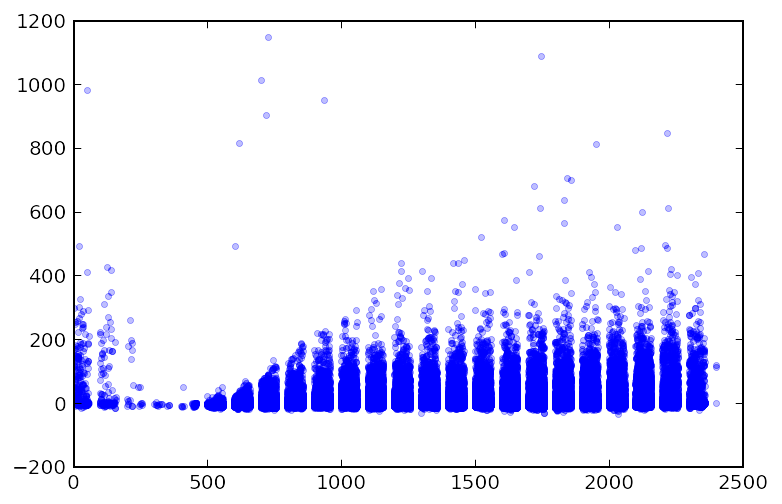

In [23]:
plt.plot(data_sample['DEP_TIME'], data_sample['DEP_DELAY'], '.', alpha = 0.5)

## Distance vs Departure time 

                            OLS Regression Results                            
Dep. Variable:               DEP_TIME   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     40.10
Date:                Wed, 09 Mar 2016   Prob (F-statistic):           2.42e-10
Time:                        13:17:55   Log-Likelihood:            -7.3323e+05
No. Observations:               96556   AIC:                         1.466e+06
Df Residuals:                   96554   BIC:                         1.466e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1347.3980      2.536    531.249      0.0

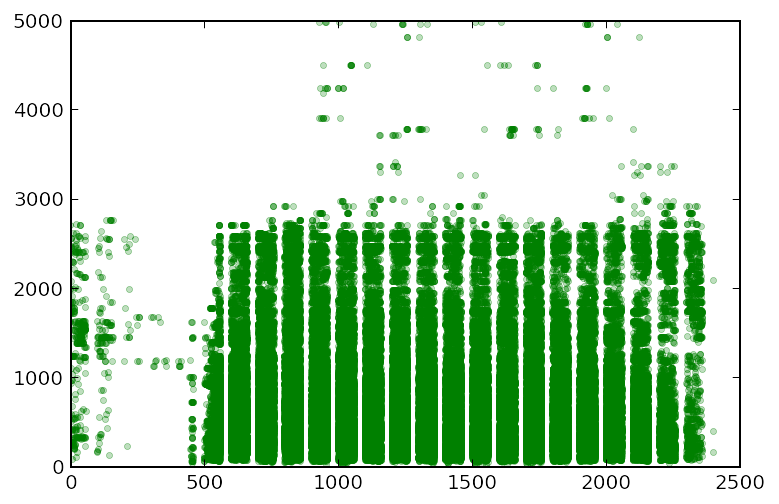

In [24]:
plt.plot( data_sample['DEP_TIME'], data_sample['DISTANCE'], '.g', alpha = 0.5)
res = smf.ols('DEP_TIME ~ DISTANCE', data = data_sample).fit()
print res.summary()

In [ ]:
# 